In [1]:
from myutils import *
from matplotlib.cm import ScalarMappable
from shapely.geometry import LineString

pf_cmap = plt.get_cmap('viridis')

In [64]:
# Rutas y nombres de archivos
path_source = '../GeoData/'
path_scenario = 'Results/scenario/'
file_scenario = 'puntosEjemplo.gpkg'
layer_scenario = 'puntosDemanda'
out = 'InstanciaEjemplo'

In [65]:
# Resultados de la instancia
with open(path_scenario+out+'_results.pkl', 'rb') as f:  
        pf = pickle.load(f)
        f.close()
pf_obj, pf_var, pf_as = pf


# Datos de la instancia
instance_name = path_scenario + out + '.pkl'
with open(instance_name, 'rb') as f:  
        instance = pickle.load(f)
        f.close()
        
origenes = instance['origenes']
destinos = instance['destinos']
origen_i_to_node = instance['origen_i_to_node']
origen_node_to_i = instance['origen_node_to_i']
destino_i_to_num = instance['destino_i_to_num']
destino_num_to_i = instance['destino_num_to_i']
destino_num_to_node = instance['destino_num_to_node']
destino_node_to_num = instance['destino_node_to_num']
capacidades = instance['capacidades']
demanda = instance['demanda']
matriz_OD = instance['matriz_OD']
rutas = instance['rutas']      

In [68]:
# Carga las pltbs
pltbs = gpd.read_file(path_source + 'PLTBs.gpkg', layer = 'PLTBs_nodes')

# Serializa los datos de tipo lista
pltbs['streets'] = pltbs['streets'].apply(json.loads)
pltbs['streets'] = pltbs['streets'].apply(lambda x: list(set(x)))
pltbs['oneway'] = pltbs['oneway'].apply(json.loads)
pltbs['length'] = pltbs['length'].apply(json.loads)
pltbs['capacity'] = pltbs['capacity'].apply(json.loads)
pltbs['grouped'] = pltbs['grouped'].apply(json.loads)
pltbs_grupos= [item for sublist in [ i for i in pltbs['grouped']] for item in sublist]
pltbs_nodos = list(pltbs['node'])
pltbs.set_index('node', inplace = True)

# Carga los colapsos
colapsos = gpd.read_file(path_scenario+file_scenario, layer = layer_scenario)
colapsos.set_index('num', inplace = True)

nodos = gpd.read_file(path_source + 'graph_transport.gpkg', layer = 'nodes')
nodos.set_index('osmid', inplace = True)

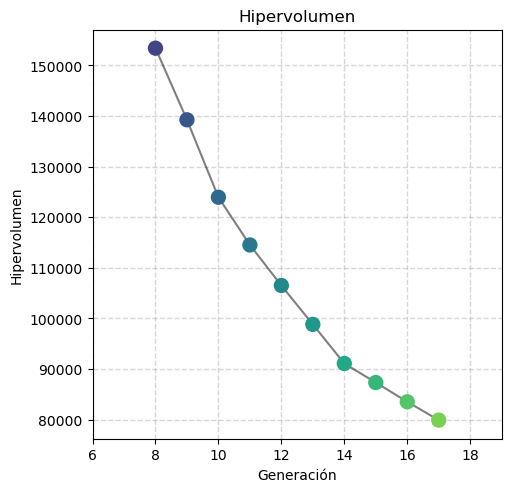

In [67]:
fig,ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)

ax.plot(pf_obj[:,1], pf_obj[:,0], c='k', alpha=0.5)
ax.scatter(pf_obj[:,1], pf_obj[:,0], s=100,
           c=[pf_cmap((i/(len(pf_obj)-1))*(0.8-0.2) + 0.2) for i in range(len(pf_obj)) ], zorder=3)


ax.set_box_aspect(1)
ax.set_xlabel('Generación')
ax.set_ylabel('Hipervolumen')
ax.set_title('Hipervolumen')
ax.set_xlim([min(pf_obj[:,1])-2,max(pf_obj[:,1])+2])
ax.grid(True, alpha=0.5, linestyle='--', linewidth=1, zorder=0)



In [ ]:
for ar in pf_as:

    bases, counts = np.unique(ar, return_counts=True)
    grupos = {origen_i_to_node[base]:i for i,base in enumerate(bases)}
    bases = [origen_i_to_node[i] for i in bases]

    destinos = [destino_i_to_num[i] for i in range(len(ar))]

    gdf_bases = pltbs.loc[bases]
    gdf_destinos = colapsos.loc[destinos]

    demanda_dict = dict([(i, int(demanda[i])) for i in range(len(ar))])
    gdf_destinos['demanda'] = gdf_destinos.index.map(demanda_dict)

    num_to_grupo = dict()
    for i,j in enumerate(ar):
        num_to_grupo[destino_i_to_num[i]] = grupos[origen_i_to_node[j]]
        
    gdf_destinos['grupo'] = gdf_destinos.apply(lambda x: num_to_grupo[x.name], axis = 1)
    

    gdf_rutas = dict()

    for j,i in enumerate(ar):
        node_base = origen_i_to_node[i]
        num_destino = destino_i_to_num[j]
        node_destino = destino_num_to_node[num_destino][1]
        
        df_ruta = rutas.get(node_destino, None)
        dist_ruta, ruta = get_route_from_df(df_ruta,node_base)
        ruta = [node_destino] + ruta
        ruta_coords = [nodos.loc[i].geometry.coords[0] for i in ruta]
        ruta_geom = LineString(ruta_coords)
        ruta_info = {'geometry':ruta_geom,
                    'length':dist_ruta,
                    'base': node_base,
                    'destino': num_destino,
                    'grupo': grupos[node_base]}
        gdf_rutas[num_destino] = ruta_info

    gdf_rutas = pd.DataFrame.from_records([i for i in gdf_rutas.values()],index='destino')
    gdf_rutas = gpd.GeoDataFrame(gdf_rutas, crs="EPSG:6369", geometry = 'geometry')

[0.3,
 0.34444444444444444,
 0.38888888888888884,
 0.4333333333333333,
 0.47777777777777775,
 0.5222222222222221,
 0.5666666666666667,
 0.6111111111111112,
 0.6555555555555554,
 0.7]